# Mass Fitting

We have to perform mass fitting based on this approach
* 1D mass fitting: One dimension fitting can be perform either on diphoton mass, dibjet mass, or reduced mass. (p.s.  Fitting reduced mass should be a task
* 2D mass fitting: two dimensions fitting, taking two mass at a time. It could be diphoton & dibjet, diphoton & reduced mass, or dibjet & reduced mass.
* 3D mass fitting: most challenging one including all of the masses.

fitting fucntions are:
- [ ] Bernstein polynomials
- [ ] Exponential functions
- [ ] Power law functions
- [ ] Landau distributions
- [ ] Kolmogorov distribution(https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test#Kolmogorov_distribution)
- [ ] Binned Likelihoods with Templates
- [ ] Johnson Distributions
- [ ] Spline Functions
- [ ]  Double-Sided Crystal Ball Function
- [ ] Generalized Hyperbolic Functions
- [ ] RooFit-specific PDFs
- [ ] Voigt Profile
- [ ] Laurent Series
- [ ] Chebyshev Polynomials

from Lata's paper, 
- For signal modeling, categorized events are fitted with a product of two parametric 
    - signal models: a sum of Gaussian distributions for mγ γ and a double-sided Crystal Ball (CB) function or the sum of a CB and a Gaussian function for mjj. The mγ γ distribution is parametrized using the sum of up to five Gaussian functions without any constraint to have a common mean.
    
 -  for the ggF H and VBF H:
     - the mjj distribution is modeled with a Bernstein polynomial; for VH production, a CB function is used to model the distribution of the hadronic decays of vector bosons;
for ttH, where the two b jets are produced from a top quark decay, a Gaussian function
with a mean value of 120GeV is used. These backgrounds are negligible for mX >550 GeV,
therefore, they are absorbed within the nonresonant background model coming from data
to simplify the signal extraction procedure.
The nonresonant background model is extracted from data using the discrete profiling
method described in refs. [68, 81]. This method makes use of polynomial and exponential
functions to decide the analytic functions to fit the background mγ γ and mjj distributions. It
estimates the systematic uncertainty associated with these functions and treats the choice of
background function as a discrete nuisance parameter in the likelihood fit to the data. For
background modeling, the fit functions are optimized on data where the events from the signal
region with 115 < mγ γ < 135 GeV are not taken into account.

## Crystal ball function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# Path to the ROOT file and tree
file_path = "../../../output_root/v2_production/signal_NMSSM/NMSSM_X400_Y150.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

# Extract diphoton mass
diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)


/tmp/sraj/ipykernel_1259645/3590830133.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1259645/3590830133.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


/tmp/sraj/ipykernel_1259645/3590830133.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1259645/3590830133.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


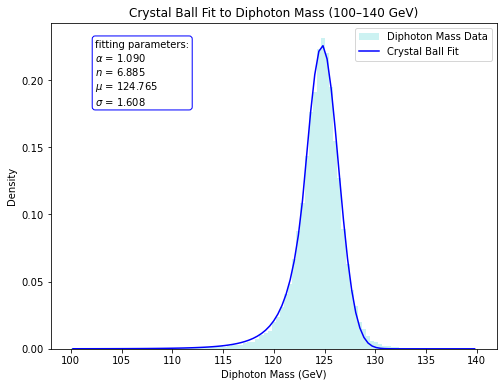

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define mass range and bins
mass_min, mass_max = 100, 140
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]
bins = np.linspace(mass_min, mass_max, 100)

# Fit Crystal Ball function
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Prepare annotation text
param_text = (
    f"fitting parameters:\n"
    f"$\\alpha$ = {params[0]:.3f}\n"
    f"$n$ = {params[1]:.3f}\n"
    f"$\\mu$ = {params[2]:.3f}\n"
    f"$\\sigma$ = {params[3]:.3f}"
)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="c", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.gca().text(
    0.10, 0.95, param_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white")
)
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100–140 GeV)")
plt.legend()

# Save
output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
# plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_massNMSSM_X400_Y150.png")
# plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_massNMSSM_X400_Y150.pdf")
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Model: sum of N Gaussians ---
def sum_of_gaussians(x, *params):
    n_gaus = len(params) // 3
    result = np.zeros_like(x)
    for i in range(n_gaus):
        amp, mu, sigma = params[3*i:3*i+3]
        result += amp * np.exp(-0.5 * ((x - mu) / sigma)**2)
    return result

# --- Individual Gaussian components for plotting ---
def gaussian_component(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

# --- Fit Function ---
def fit_multiple_gaussians(data, bins, n_gaussians=4):
    hist_vals, bin_edges = np.histogram(data, bins=bins, density=True)
    x = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    y = hist_vals

    # Initial guess: spread mu, fixed sigma, scaled amp
    mus = np.linspace(mass_min + 2, mass_max - 2, n_gaussians)
    sigmas = [1.5] * n_gaussians
    amps = [max(y) / n_gaussians] * n_gaussians
    p0 = [val for triple in zip(amps, mus, sigmas) for val in triple]
    
    
    # Bounds: amp > 0, sigma > 0
    lower_bounds = [0, mass_min, 0.1] * n_gaussians
    upper_bounds = [1.0, mass_max, 10.0] * n_gaussians
    
    
    popt, pcov = curve_fit(
        lambda x, *p: sum_of_gaussians(x, *p), x, y, p0=p0,
        bounds=(lower_bounds, upper_bounds)
    )

    fit_y = sum_of_gaussians(x, *popt)
    chi2 = np.sum(((y - fit_y) ** 2) / (fit_y + 1e-10))  # avoid div-by-zero
    ndof = len(y) - len(popt)

    return x, y, popt, chi2, ndof

In [20]:
import matplotlib.pyplot as plt

def plot_gaussians_fit_with_components(x, y, popt, chi2, ndof, title=" ", save_path=None):
    # Use high-contrast sans-serif fonts (cleaner and darker)
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.size": 13,
        "axes.labelcolor": "black",
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.edgecolor": "black",
        "xtick.direction": "in",
        "ytick.direction": "in"
    })

    plt.figure(figsize=(8.5, 6))

    # Plot data points with vertical "error bars"
    plt.errorbar(x, y, yerr=np.sqrt(y), fmt='ko', label="Simulation", markersize=4, capsize=1)

    # Total fit
    fit_y = sum_of_gaussians(x, *popt)
    plt.plot(x, fit_y, 'k-', linewidth=1.5, label="Parametric Model")

    # Individual Gaussians
    n_gaus = len(popt) // 3
    colors = ['deepskyblue', 'lightcoral', 'goldenrod', 'mediumseagreen', 'purple']
    for i in range(n_gaus):
        amp, mu, sigma = popt[3*i:3*i+3]
        y_comp = gaussian_component(x, amp, mu, sigma)
        plt.plot(x, y_comp, linestyle='--', linewidth=1.2, color=colors[i % len(colors)],
                 label=f'gaus\_g{i}')

    # CMS label (top-left)
    plt.text(0.03, 1.02, "CMS", transform=plt.gca().transAxes,
             fontsize=15, fontweight='bold')
    plt.text(0.12, 1.02, "Simulation", transform=plt.gca().transAxes,
             fontsize=13, style='italic')

    # Energy info (top-right)
    plt.text(0.75, 1.02, "13.6 TeV", transform=plt.gca().transAxes, fontsize=13)

    # Chi2 label (bottom right)
    chi2_text = rf"$\chi^2$/n(dof) = {chi2/ndof:.4f}"
    plt.text(0.70, 0.83, chi2_text, transform=plt.gca().transAxes, fontsize=12)

    # Axes labels
    plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=14, loc="right")
    plt.ylabel("Events / 0.5 GeV", fontsize=14, loc="top")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    label_order = ['Simulation', 'Parametric Model'] + [f'gaus\\_g{i}' for i in range(n_gaus)]
    sorted_handles = [handles[labels.index(l)] for l in label_order if l in labels]
    sorted_labels = [l for l in label_order if l in labels]
    plt.legend(sorted_handles, sorted_labels, fontsize=11, loc='upper right', frameon=False)

    # Final tweaks and save
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + ".png", dpi=300, bbox_inches='tight')
        plt.savefig(save_path + ".pdf", bbox_inches='tight')
    plt.show()


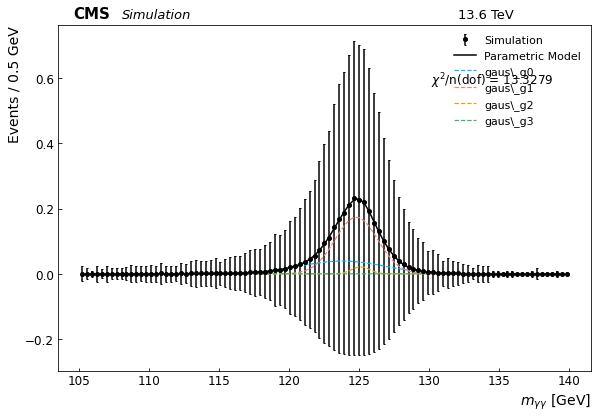

In [21]:
# Define range and bins
mass_min, mass_max = 105, 140
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]
bins = np.linspace(mass_min, mass_max, 100)

# Fit
x, y, popt, chi2, ndof = fit_multiple_gaussians(filtered_mass, bins, n_gaussians=4)

# Plot
plot_gaussians_fit_with_components(
    x, y, popt, chi2, ndof,
#     title="Sum of 4 Gaussians Fit to $m_{\gamma\gamma}$ (Simulated)",
    save_path="/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/SumGaussFit_NMSSM_X400_Y150"
)


In [5]:
# Fixing thr error bar

import numpy as np
from scipy.optimize import curve_fit

def sum_of_gaussians(x, *params):
    """Sum of N Gaussians. Each Gaussian: amp, mu, sigma."""
    y = np.zeros_like(x)
    for i in range(len(params) // 3):
        amp, mu, sigma = params[3*i:3*i+3]
        y += amp * np.exp(-0.5 * ((x - mu) / sigma)**2)
    return y

def gaussian_component(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)


In [6]:
def fit_multiple_gaussians(data, bins, n_gaussians=4):
    hist_vals, bin_edges = np.histogram(data, bins=bins, density=False)
    x = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    y = hist_vals
    y_err = np.sqrt(y)

    # Initial guesses
    amps = [max(y) / n_gaussians] * n_gaussians
    mus = np.linspace(min(data), max(data), n_gaussians)
    sigmas = [1.0] * n_gaussians
    p0 = [val for triple in zip(amps, mus, sigmas) for val in triple]

    # Set bounds: amp > 0, sigma > 0
    lower_bounds = [0, min(data), 0.1] * n_gaussians
    upper_bounds = [np.inf, max(data), 10.0] * n_gaussians

    popt, _ = curve_fit(
        lambda x, *p: sum_of_gaussians(x, *p),
        x, y, p0=p0, bounds=(lower_bounds, upper_bounds),
        maxfev=100000  # Increase default (was 800 * len(p0))

    )
    y_fit = sum_of_gaussians(x, *popt)
    chi2 = np.sum(((y - y_fit)**2) / (y + 1e-6))  # avoid divide-by-zero
    ndof = len(y) - len(popt)

    return x, y, np.sqrt(y), popt, chi2, ndof


In [9]:
import matplotlib.pyplot as plt

def plot_gaussians_fit_with_components(x, y, yerr, popt, chi2, ndof, title=" ", save_path=None):
    # CMS-style font settings
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.size": 13,
        "axes.labelcolor": "black",
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.edgecolor": "black",
        "xtick.direction": "in",
        "ytick.direction": "in"
    })

    plt.figure(figsize=(8.5, 6))

    # Plot data with error bars
    plt.errorbar(x, y, yerr=yerr, fmt='ko', label="Simulation", markersize=4, capsize=1)

    # Plot total fit
    fit_y = sum_of_gaussians(x, *popt)
    plt.plot(x, fit_y, 'k-', linewidth=1.5, label="Parametric Model")

    # Individual Gaussians
    n_gaus = len(popt) // 3
    colors = ['deepskyblue', 'lightcoral', 'goldenrod', 'mediumseagreen', 'purple']
    for i in range(n_gaus):
        amp, mu, sigma = popt[3*i:3*i+3]
        y_comp = gaussian_component(x, amp, mu, sigma)
        plt.plot(x, y_comp, linestyle='--', linewidth=1.2, color=colors[i % len(colors)],
                 label=f'gaus\_g{i}')

    # CMS Simulation label
    plt.text(0.03, 1.02, "CMS", transform=plt.gca().transAxes,
             fontsize=15, fontweight='bold')
    plt.text(0.12, 1.02, "Simulation", transform=plt.gca().transAxes,
             fontsize=13, style='italic')

    # Energy label
    plt.text(0.75, 1.02, "13.6 TeV", transform=plt.gca().transAxes, fontsize=13)

    # Chi-squared
    chi2_text = rf"$\chi^2$/n(dof) = {chi2/ndof:.4f}"
    plt.text(0.10, 0.83, chi2_text, transform=plt.gca().transAxes, fontsize=12)

    # Labels and ticks
    plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=14, loc="right")
    plt.ylabel("Events / bin", fontsize=14, loc="top")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    label_order = ['Simulation', 'Parametric Model'] + [f'gaus\\_g{i}' for i in range(n_gaus)]
    sorted_handles = [handles[labels.index(l)] for l in label_order if l in labels]
    sorted_labels = [l for l in label_order if l in labels]
    plt.legend(sorted_handles, sorted_labels, fontsize=11, loc='upper right', frameon=False)

    # Save
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + ".png", dpi=300, bbox_inches='tight')
        plt.savefig(save_path + ".pdf", bbox_inches='tight')
    plt.show()


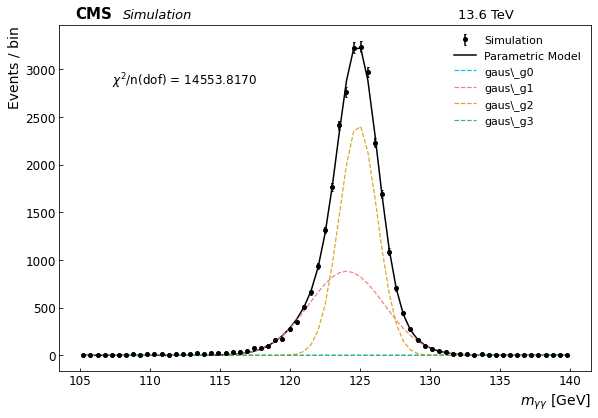

In [10]:
# Define range and bins
mass_min, mass_max = 105, 140
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]
bins = np.linspace(mass_min, mass_max, 70)

# Fit
x, y, yerr, popt, chi2, ndof = fit_multiple_gaussians(filtered_mass, bins, n_gaussians=4)

# Plot
plot_gaussians_fit_with_components(
    x, y, yerr, popt, chi2, ndof,
    title="",
    save_path="/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/SumGaussFit_NMSSM_X400_Y150"
)


# F-test

In [33]:
from scipy.stats import f

def f_test(chi2_1, dof_1, chi2_2, dof_2):
    """Compare simpler model (1) vs complex model (2)"""
    numerator = (chi2_1 - chi2_2) / (dof_1 - dof_2)
    denominator = chi2_2 / dof_2
    F = numerator / denominator
    p_value = 1 - f.cdf(F, dof_1 - dof_2, dof_2)
    return F, p_value


In [34]:
def scan_n_gaussians(data, bins, n_max=5):
    results = []
    for n in range(1, n_max + 1):
        try:
            x, y, yerr, popt, chi2, ndof = fit_multiple_gaussians(data, bins, n)
            results.append({
                "n_gauss": n,
                "chi2": chi2,
                "ndof": ndof,
                "chi2_ndof": chi2 / ndof,
                "popt": popt
            })
        except RuntimeError:
            print(f"Fit failed for {n} Gaussians.")
    return results


In [35]:
def find_optimal_n(results, p_threshold=0.05):
    for i in range(len(results) - 1):
        chi2_1, ndof_1 = results[i]["chi2"], results[i]["ndof"]
        chi2_2, ndof_2 = results[i+1]["chi2"], results[i+1]["ndof"]
        _, p_value = f_test(chi2_1, ndof_1, chi2_2, ndof_2)
        if p_value > p_threshold:
            return results[i]["n_gauss"]  # stop increasing if added Gaussian not justified
    return results[-1]["n_gauss"]


In [38]:
def plot_chi2_ndof_vs_n(results, optimal_n, save_path=None):
    import matplotlib.pyplot as plt

    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 14,
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.edgecolor": "black",
        "xtick.direction": "in",
        "ytick.direction": "in"
    })

    x_vals = [r["n_gauss"] for r in results]
    y_vals = [r["chi2_ndof"] for r in results]

    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, y_vals, 'o-', color='red')
    plt.xlabel(r"$N_{\mathrm{gauss}}$")
    plt.ylabel(r"$\chi^2/\mathrm{n(dof)}$")
    plt.ylim(0, max(y_vals) * 1.2)

    # Annotate optimal N
    plt.axvline(optimal_n, color='gray', linestyle='--')
    plt.text(optimal_n + 0.1, max(y_vals) * 0.9,
             rf"Optimum $N_{{\mathrm{{gauss}}}}$ = {optimal_n}",
             fontsize=13)

    # CMS-style header
    plt.text(0.02, 1.03, "CMS", transform=plt.gca().transAxes,
             fontsize=16, fontweight='bold')
    plt.text(0.12, 1.03, "Simulation", transform=plt.gca().transAxes,
             fontsize=13, style='italic')
    plt.text(0.90, 1.03, "13.6 TeV", transform=plt.gca().transAxes, fontsize=13)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path + ".png", dpi=300, bbox_inches='tight')
        plt.savefig(save_path + ".pdf", bbox_inches='tight')
    plt.show()


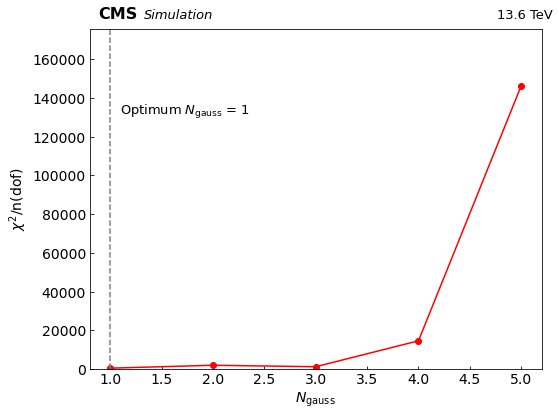

In [39]:
# Histogram range
mass_min, mass_max = 105, 140
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]
bins = np.linspace(mass_min, mass_max, 70)

# Scan
results = scan_n_gaussians(filtered_mass, bins, n_max=5)
optimal_n = find_optimal_n(results)

# Plot
plot_chi2_ndof_vs_n(
    results,
    optimal_n,
    save_path="/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/FTest_NGaussians"
)


In [11]:
import ROOT
import numpy as np

# Open a new ROOT file to store the fitted signal
fout = ROOT.TFile("fit_shapes.root", "UPDATE")

# Define the histogram
hist_sig = ROOT.TH1F("NMSSM_X400_Y150", "Crystal Ball Fit Signal", len(bin_centers) - 1, bin_centers)

# Fill the histogram with the fitted values
for i in range(len(bin_centers)):
    hist_sig.SetBinContent(i + 1, fitted_curve_cb[i])  # Use the Crystal Ball fit values

# Save the histogram to the ROOT file
hist_sig.Write()
fout.Close()


In [4]:
def sum_of_gaussians(x, *params):
    """
    Sum of N Gaussian functions.
    params = [amp1, mu1, sigma1, amp2, mu2, sigma2, ..., ampN, muN, sigmaN]
    """
    n_gaussians = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        amp = params[3*i]
        mu = params[3*i+1]
        sigma = params[3*i+2]
        y += amp * np.exp(-0.5 * ((x - mu)/sigma)**2)
    return y


In [5]:
from scipy.optimize import curve_fit
from scipy.stats import f

def fit_n_gaussians(data, bins, max_gaussians=5):
    y_data, bin_edges = np.histogram(data, bins=bins, density=True)
    x_data = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    models = []
    chi2s = []
    dofs = []

    for n in range(1, max_gaussians + 1):
        # Initial guesses: evenly spaced mus, constant sigma, amp from data
        amp_guess = [max(y_data)/n] * n
        mu_guess = np.linspace(min(data), max(data), n)
        sigma_guess = [1.0] * n
        p0 = []
        for a, m, s in zip(amp_guess, mu_guess, sigma_guess):
            p0 += [a, m, s]
        
        try:
            popt, pcov = curve_fit(lambda x, *p: sum_of_gaussians(x, *p), x_data, y_data, p0=p0)
            y_fit = sum_of_gaussians(x_data, *popt)
            chi2 = np.sum(((y_data - y_fit) ** 2) / y_fit)
            dof = len(y_data) - len(popt)
            models.append((n, popt, chi2, dof))
            chi2s.append(chi2)
            dofs.append(dof)
        except Exception as e:
            print(f"Fit failed for {n} Gaussians: {e}")
            continue

    return models


In [6]:
def f_test(chi2_1, dof_1, chi2_2, dof_2):
    """Compare two models using F-test. Model 2 is more complex."""
    numerator = (chi2_1 - chi2_2) / (dof_1 - dof_2)
    denominator = chi2_2 / dof_2
    F = numerator / denominator
    p_value = 1 - f.cdf(F, dof_1 - dof_2, dof_2)
    return F, p_value


NameError: name 'x_data' is not defined

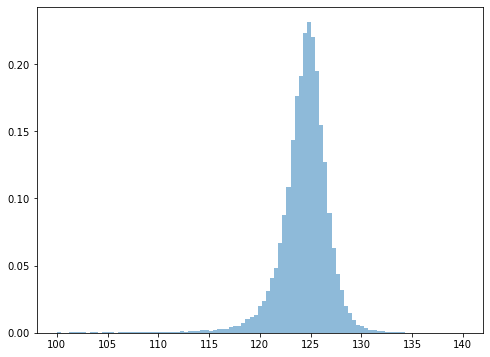

In [7]:
plt.figure(figsize=(8,6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.5, label="Data")
plt.plot(x_data, sum_of_gaussians(x_data, *best_popt), 'r-', label=f"{best_n}-Gaussian Fit")
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.title("Sum of Gaussians Fit to Diphoton Mass")
plt.show()


# Dibjet($M_{jj}$)


In [1]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v2_production/signal_NMSSM/NMSSM_X400_Y125.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


# Double Side Crystal ball

/tmp/sraj/ipykernel_1800569/2378819391.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/2378819391.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1800569/2378819391.py:14: RuntimeWarning: invalid value encountered in double_scalars
  A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/2378819391.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/2378819391.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/2378819391.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


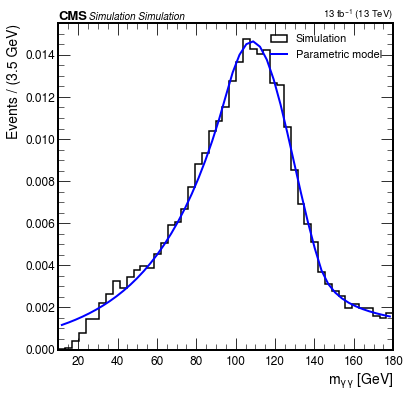

Fitted DSCB Parameters:
  Alpha1 = 0.604,  N1 = 131.785
  Alpha2 = 1.609,  N2 = 0.512
  Mu = 108.319,  Sigma = 21.330
Chi-squared / dof: 0.00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # Import mplhep for CMS style
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 10, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Histogram (No error bars)
plt.hist(filtered_mass, bins=bins, density=True, histtype='step', color="black", linewidth=1.5, label="Simulation")

# Fit curve
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
hep.cms.label("Simulation", data=False, lumi=13, loc=0)

# Labels
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")


/tmp/sraj/ipykernel_1800569/1896294308.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1896294308.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1800569/1896294308.py:14: RuntimeWarning: invalid value encountered in double_scalars
  A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1896294308.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1896294308.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1896294308.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1896294308.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


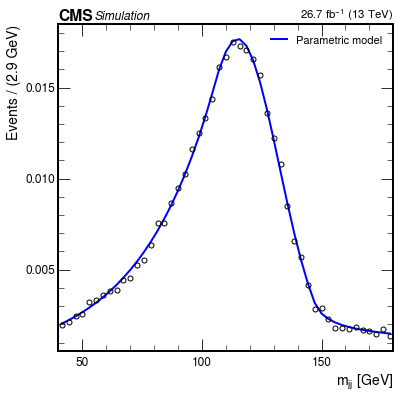

Fitted DSCB Parameters:
  Alpha1 = 0.549,  N1 = 129.869
  Alpha2 = 1.842,  N2 = 0.316
  Mu = 114.957,  Sigma = 17.376
Chi-squared / dof: 0.00


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # CMS-style plotting
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 40, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Plot simulation points (black circles)
plt.errorbar(bin_centers, hist_vals, fmt="o", color="black", markersize=5, label="",markerfacecolor='none')

# Plot the parametric model (smooth blue curve)
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
# Apply CMS Label with "Preliminary"
hep.cms.label(data=False, lumi=26.7, loc=0, fontsize=12, label="")

# Labels
plt.xlabel(r"$m_{jj}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

# # Add fit parameters to the plot
# param_text = (
#     rf"$\alpha_1 = {params_dscb[0]:.2f}$" + "\n" +
#     rf"$n_1 = {params_dscb[1]:.2f}$" + "\n" +
#     rf"$\alpha_2 = {params_dscb[2]:.2f}$" + "\n" +
#     rf"$n_2 = {params_dscb[3]:.2f}$" + "\n" +
#     rf"$\mu = {params_dscb[4]:.2f}$ GeV" + "\n" +
#     rf"$\sigma = {params_dscb[5]:.2f}$ GeV" + "\n" +
#     rf"$\chi^2/\mathrm{{dof}} = {chi2_dscb:.2f}$"
# )

# # Place the text in the upper left
# plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, 
#          fontsize=12, verticalalignment='top', horizontalalignment = 'right',
#          bbox=dict(boxstyle="round,pad=0.3", 
#                    edgecolor="black", facecolor="white"))

output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X400_Y125.png")
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X400_Y125.pdf")
plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")


## signal X500

In [11]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v2_production/signal_NMSSM/NMSSM_X500_Y125.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


/tmp/sraj/ipykernel_1800569/1762725064.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1762725064.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1800569/1762725064.py:14: RuntimeWarning: invalid value encountered in double_scalars
  A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1762725064.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1762725064.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1762725064.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1762725064.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


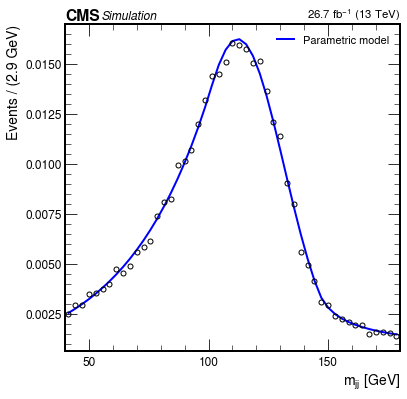

Fitted DSCB Parameters:
  Alpha1 = 0.554,  N1 = 130.051
  Alpha2 = 1.709,  N2 = 0.482
  Mu = 112.202,  Sigma = 19.446
Chi-squared / dof: 0.00


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # CMS-style plotting
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 40, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Plot simulation points (black circles)
plt.errorbar(bin_centers, hist_vals, fmt="o", color="black", markersize=5, label="",markerfacecolor='none')

# Plot the parametric model (smooth blue curve)
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
# Apply CMS Label with "Preliminary"
hep.cms.label(data=False, lumi=26.7, loc=0, fontsize=12, label="")

# Labels
plt.xlabel(r"$m_{jj}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

# # Add fit parameters to the plot
# param_text = (
#     rf"$\alpha_1 = {params_dscb[0]:.2f}$" + "\n" +
#     rf"$n_1 = {params_dscb[1]:.2f}$" + "\n" +
#     rf"$\alpha_2 = {params_dscb[2]:.2f}$" + "\n" +
#     rf"$n_2 = {params_dscb[3]:.2f}$" + "\n" +
#     rf"$\mu = {params_dscb[4]:.2f}$ GeV" + "\n" +
#     rf"$\sigma = {params_dscb[5]:.2f}$ GeV" + "\n" +
#     rf"$\chi^2/\mathrm{{dof}} = {chi2_dscb:.2f}$"
# )

# # Place the text in the upper left
# plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, 
#          fontsize=12, verticalalignment='top', horizontalalignment = 'right',
#          bbox=dict(boxstyle="round,pad=0.3", 
#                    edgecolor="black", facecolor="white"))

output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X500_Y125.png")
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X500_Y125.pdf")
plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")


# X550

In [16]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v2_production/signal_NMSSM/NMSSM_X550_Y125.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


/tmp/sraj/ipykernel_1800569/1792789944.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1792789944.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1800569/1792789944.py:14: RuntimeWarning: invalid value encountered in double_scalars
  A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1792789944.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1792789944.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/1792789944.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/1792789944.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


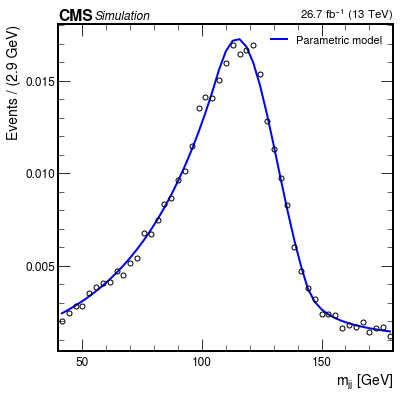

Fitted DSCB Parameters:
  Alpha1 = 0.482,  N1 = 127.276
  Alpha2 = 1.722,  N2 = 0.460
  Mu = 114.783,  Sigma = 16.899
Chi-squared / dof: 0.00


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # CMS-style plotting
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 40, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Plot simulation points (black circles)
plt.errorbar(bin_centers, hist_vals, fmt="o", color="black", markersize=5, label="",markerfacecolor='none')

# Plot the parametric model (smooth blue curve)
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
# Apply CMS Label with "Preliminary"
hep.cms.label(data=False, lumi=26.7, loc=0, fontsize=12, label="")

# Labels
plt.xlabel(r"$m_{jj}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

# # Add fit parameters to the plot
# param_text = (
#     rf"$\alpha_1 = {params_dscb[0]:.2f}$" + "\n" +
#     rf"$n_1 = {params_dscb[1]:.2f}$" + "\n" +
#     rf"$\alpha_2 = {params_dscb[2]:.2f}$" + "\n" +
#     rf"$n_2 = {params_dscb[3]:.2f}$" + "\n" +
#     rf"$\mu = {params_dscb[4]:.2f}$ GeV" + "\n" +
#     rf"$\sigma = {params_dscb[5]:.2f}$ GeV" + "\n" +
#     rf"$\chi^2/\mathrm{{dof}} = {chi2_dscb:.2f}$"
# )

# # Place the text in the upper left
# plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, 
#          fontsize=12, verticalalignment='top', horizontalalignment = 'right',
#          bbox=dict(boxstyle="round,pad=0.3", 
#                    edgecolor="black", facecolor="white"))

output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X550_Y125.png")
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X550_Y125.pdf")
plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")


# 600

In [18]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v2_production/signal_NMSSM/NMSSM_X600_Y125.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


/tmp/sraj/ipykernel_1800569/3818680332.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/3818680332.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1800569/3818680332.py:14: RuntimeWarning: invalid value encountered in double_scalars
  A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/3818680332.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/3818680332.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1800569/3818680332.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1800569/3818680332.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


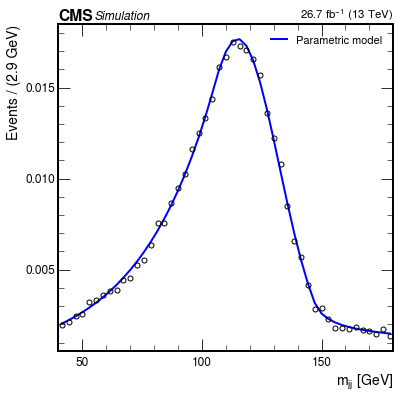

Fitted DSCB Parameters:
  Alpha1 = 0.549,  N1 = 129.869
  Alpha2 = 1.842,  N2 = 0.316
  Mu = 114.957,  Sigma = 17.376
Chi-squared / dof: 0.00


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # CMS-style plotting
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 40, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Plot simulation points (black circles)
plt.errorbar(bin_centers, hist_vals, fmt="o", color="black", markersize=5, label="",markerfacecolor='none')

# Plot the parametric model (smooth blue curve)
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
# Apply CMS Label with "Preliminary"
hep.cms.label(data=False, lumi=26.7, loc=0, fontsize=12, label="")

# Labels
plt.xlabel(r"$m_{jj}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

# # Add fit parameters to the plot
# param_text = (
#     rf"$\alpha_1 = {params_dscb[0]:.2f}$" + "\n" +
#     rf"$n_1 = {params_dscb[1]:.2f}$" + "\n" +
#     rf"$\alpha_2 = {params_dscb[2]:.2f}$" + "\n" +
#     rf"$n_2 = {params_dscb[3]:.2f}$" + "\n" +
#     rf"$\mu = {params_dscb[4]:.2f}$ GeV" + "\n" +
#     rf"$\sigma = {params_dscb[5]:.2f}$ GeV" + "\n" +
#     rf"$\chi^2/\mathrm{{dof}} = {chi2_dscb:.2f}$"
# )

# # Place the text in the upper left
# plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, 
#          fontsize=12, verticalalignment='top', horizontalalignment = 'right',
#          bbox=dict(boxstyle="round,pad=0.3", 
#                    edgecolor="black", facecolor="white"))

output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X600_Y125.png")
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass_X600_Y125.pdf")
plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")
